i=0 np.std(areas)=0.5881582535853617
i=1000 np.std(areas)=0.2365677587466006
i=2000 np.std(areas)=0.1914508129913589
i=3000 np.std(areas)=0.19648779195514562
i=4000 np.std(areas)=0.1569954703122985
i=5000 np.std(areas)=0.19637762949414095
i=6000 np.std(areas)=0.1561368527010731
i=7000 np.std(areas)=0.1553629029334625
i=8000 np.std(areas)=0.15342976449173176
i=9000 np.std(areas)=0.1531677719943925
i=10000 np.std(areas)=0.1977235744660985
i=11000 np.std(areas)=0.19755725100936
i=12000 np.std(areas)=0.19660594826735547
i=13000 np.std(areas)=0.1542583456519297
i=14000 np.std(areas)=0.19735792264884044
i=15000 np.std(areas)=0.19747410871780774
i=16000 np.std(areas)=0.15549314850418322
i=17000 np.std(areas)=0.19739613169338058
i=18000 np.std(areas)=0.1538087926440879
i=19000 np.std(areas)=0.15409067743333332


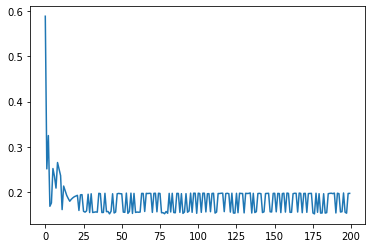

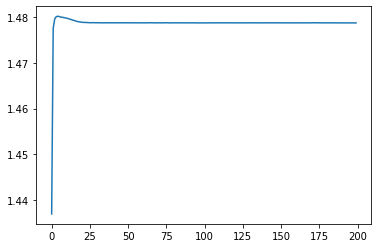

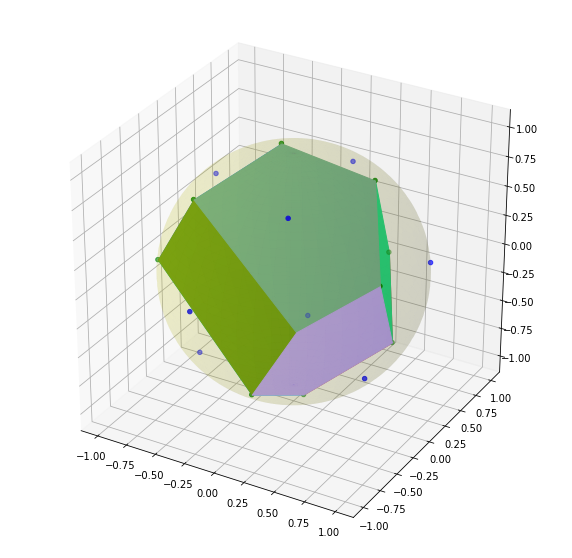

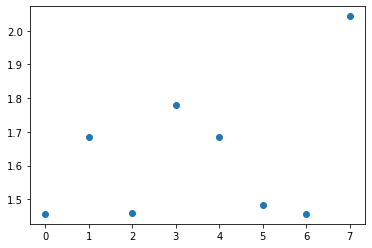

平均1.6308628191331973
標準偏差0.19667595383171269
中心[ 0.00038726 -0.000104   -0.00010346]


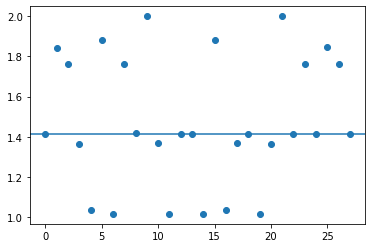

In [90]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import SphericalVoronoi
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import colors
import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

def distance(point_from, point_to):
    return math.sqrt( (point_from[0] - point_to[0]) ** 2
                    + (point_from[1] - point_to[1]) ** 2
                    + (point_from[2] - point_to[2]) ** 2)

class Sphere():
    """球のクラス"""
    def __init__(self, center=np.array([0.0, 0.0, 0.0]), radius=1.0, points=0):
        self.center, self.radius = center, float(radius)
        self.points = np.empty((0,3))
        self.add_random_point(0)
        self.step = 0

    def plot(self, elev=30, azim=30):
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')
        u,v=np.mgrid[0:2*np.pi:50j, 0:np.pi:25j]
        x=np.cos(u)*np.sin(v)
        y=np.sin(u)*np.sin(v)
        z=np.cos(v)
        ax.plot_wireframe(x, y, z, color='lightskyblue', linewidth=0.5)
        crds = self.points.T
        ax.plot(crds[0], crds[1], crds[2], marker='o', linestyle='None',)
        ax.view_init(elev=elev, azim=azim)
        plt.show()
        
    def add_random_point(self, number=1):
        """numberの数だけ球面上にランダムな点を加える"""
        for _ in range(number):
            theta = random.random() * math.pi
            phi = random.random() * math.pi * 2
            z = random.random() * 2 - 1
            self.points = np.append(
                self.points,
                [[self.radius * math.sqrt(1 - (z ** 2)) * math.cos(phi),
                  self.radius * math.sqrt(1 - (z ** 2)) * math.sin(phi),
                  self.radius * z]],
                axis=0)
            
    def bind_point_on_surface(self, point: np.ndarray) -> np.ndarray:
        """点を受け取りその点を球面上に落とした点を返す"""
        factor = self.radius / distance(point, self.center)
        return point * factor
    
    def bind_all_points(self): 
        """全ての点を球面上に落とす"""
        for i, point in enumerate(self.points):
            self.points[i] = self.bind_point_on_surface(point)
            
    def snap_to_center(self):
        """全点の重心を球の中心と一致させる"""
        calculated_center = self.points.mean(axis=0)
        vector_to_move = self.center - calculated_center
        self.points += vector_to_move
        
    def move3(self, constant=-1, power=2, cutoff=2.0):
        """全ての点に対し距離のpower乗に反比例し、constantが正なら引力、負なら斥力"""
        new_points = np.empty((len(self.points), 3), float)
        for i, point in enumerate(self.points):
            vector = np.array([0.0, 0.0, 0.0])
            for target in self.points:
                if (point == target).all():
                    continue
                v = target - point
                d = np.linalg.norm(v)
                nv = v / d
                if d < cutoff:
                    vector += v * constant / (d ** power)
            new_points[i] = point + vector
        logger.debug("new_points=%S", new_points)
        self.points = new_points
        self.step += 1
        
    def voronoi(self, plot=False):
        """球面ボロノイによる評価"""
        areas = []
        points = self.points
        center = self.center
        sv = SphericalVoronoi(points, self.radius, center)
        # 面積を計算
        for region in sv.regions:
            triangles = []
            number_of_triangles = len(region) - 2
            for n in range(number_of_triangles):
                triangles.append([region[0], region[n+1], region[n+2]])
            angle = 0
            for triangle in triangles:
                O = self.center
                A = sv.vertices[triangle[0]] - O
                B = sv.vertices[triangle[1]] - O
                C = sv.vertices[triangle[2]] - O
                cAB = np.cross(A, B)
                cAB = cAB / np.linalg.norm(cAB)
                cBC = np.cross(B, C)
                cBC = cBC / np.linalg.norm(cBC)
                cCA = np.cross(C, A)
                cCA = cCA / np.linalg.norm(cCA)
                ABBC = max(-1.0, min(1.0, np.dot(cAB, -cBC)))
                BCCA = max(-1.0, min(1.0, np.dot(cBC, -cCA)))
                CAAB = max(-1.0, min(1.0, np.dot(cCA, -cAB)))
                a = 0
                a += math.acos(ABBC)
                a += math.acos(BCCA)
                a += math.acos(CAAB)
                a -= math.pi
                angle += a
            areas.append(angle)
            
        if plot:
            # sort vertices (optional, helpful for plotting)
            sv.sort_vertices_of_regions()
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111, projection='3d')
            # plot the unit sphere for reference (optional)
            u = np.linspace(0, 2 * np.pi, 100)
            v = np.linspace(0, np.pi, 100)
            x = np.outer(np.cos(u), np.sin(v))
            y = np.outer(np.sin(u), np.sin(v))
            z = np.outer(np.ones(np.size(u)), np.cos(v))
            ax.plot_surface(x, y, z, color='y', alpha=0.1)
            # plot generator points
            ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b')
            # plot Voronoi vertices
            ax.scatter(sv.vertices[:, 0], sv.vertices[:, 1], sv.vertices[:, 2], c='g')
            # indicate Voronoi regions (as Euclidean polygons)
            for region in sv.regions:
                random_color = colors.rgb2hex(np.random.rand(3))
                polygon = Poly3DCollection([sv.vertices[region]], alpha=1.0)
                polygon.set_color(random_color)
                ax.add_collection3d(polygon)
            plt.show()
        return areas
    
    def edges(self):
        edges = []
        for i, point in enumerate(self.points):
            for target in self.points[i+1:]:
                edges.append(np.linalg.norm(target - point))
        return edges
    
    def save(self, filename='', directory=''):
        if filename == '':
            filename = f'{len(self.points)}_{self.step}.points'
        if directory:
            filename = directory + filename
        np.savetxt(filename, self.points)
    
sphere = Sphere()
sphere.add_random_point(8)
PLOT_FREQ = 100
LOG_FREQ = 1000
SAVE_FREQ = 10000
CUTOFF = 1.415
POWER = 2
CONST = -0.005
trajectory = []
edge_trajectory = []
for i in range(20000):
    sphere.move3(constant=CONST, power=POWER, cutoff=CUTOFF)
    sphere.snap_to_center()
    sphere.bind_all_points()
    if i % PLOT_FREQ == 0:
        areas = sphere.voronoi()
        trajectory.append(np.std(areas))
        edges = sphere.edges()
        edge_trajectory.append(np.mean(edges))
    if i % LOG_FREQ == 0:
        areas = sphere.voronoi()
        print(f'{i=} {np.std(areas)=}')
    if i % SAVE_FREQ == 0:
        sphere.save()
plt.plot(trajectory)
plt.show()
plt.plot(edge_trajectory)
plt.show()
areas = sphere.voronoi(plot=True)
plt.plot(areas, 'o')
plt.show()
print(f"平均{np.mean(areas)}")
print(f"標準偏差{np.std(areas)}")
print(f"中心{sphere.points.mean(axis=0)}")
edges = sphere.edges()
plt.plot(edges, 'o')
plt.axhline(CUTOFF)
plt.show()


In [69]:
np.savetxt('points', sphere.points)